In [1]:
#Import Statements

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
import dask.dataframe as dd
import json
from scipy import stats
from pandas.io.json import json_normalize
import random
import time

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

<h1>Reading and PreProcessing Methods<h1>

In [2]:
#Reference link: https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue

#Reading files and flattening JSON columns
def load_df(csv_path):
    """Flatten the JSON columns of a dataframe"""
    
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}
                     )
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print("Shape of the dataframe: ", df.shape)

    return df

In [3]:
def preprocessing(dataframe, name = 'train_set'):
    """Preprocessing method to drop few columns and flatten JSON columns"""
    
    #Dropping such columns which have constant values throughout the data since they are not going to contribute anything to our model
    drop_columns = ['hits', 'socialEngagementType']
    dataframe = dataframe.drop(drop_columns, axis=1)
    
    #Converting dask dataframe to pandas dataframe
    dataframe.compute().to_csv('dataframe_less_col.csv', index = False)
    
    #Flattening JSON columns
    dataframe_path = 'dataframe_less_col.csv'
    dataframe = load_df(dataframe_path) #Function call
    
    if (name=='train_set'):
        #Identifying and removing constant features from our dataset (i.e. the features which have same value throughout the dataset), 
        #hence they won't contribute anything in the learnin of the model.
        constant_features = []
        for col in dataframe.columns:
            if (dataframe[col].nunique()==1):
                constant_features.append(col)

        #Dropping constant feature:
        dataframe.drop(columns=constant_features, axis=1, inplace=True)
    
    else:
        #Dropping all such columns from test that are not present in train. Since, in the above EDA we found out certain columns which 
        #won't be useful for modelling purpose
        drop_columns_list = list(set(dataframe.columns) - set(df_train.columns))
        dataframe.drop(columns=drop_columns_list, axis=1, inplace=True)
        
    dataframe.reset_index(inplace=True, drop=True)

    return dataframe

In [4]:
#Reading and Preprocessing Train dataset
print('*'*52 + 'Train Set Preprocessing' + '*'*52)
df_train = dd.read_csv(r'E:\Applied AI\Case Study - 1\Google Analytics Customer Revenue Prediction (Data)\train_v2.csv', dtype={'fullVisitorId': 'object'})
df_train = preprocessing(df_train, 'train_set')
# df_train = pd.read_csv(r'E:\Applied AI\Case Study - 1\Google Analytics Customer Revenue Prediction (Data)\train_v2_even_less_col.csv', dtype={'fullVisitorId': 'object'}, low_memory=False)
print("Some useful statistics: \n")
print("Shape of dataset: ", df_train.shape)
print("#Unique Customers in dataframe: ", df_train.fullVisitorId.nunique())
print('*'*52 + 'Train Set Preprocessing' + '*'*52)

#Reading and Preprocessing Test dataset
print('*'*52 + 'Test Set Preprocessing' + '*'*52)
df_test = dd.read_csv(r'E:\Applied AI\Case Study - 1\Google Analytics Customer Revenue Prediction (Data)\test_v2.csv', dtype={'fullVisitorId': 'object'})
df_test = preprocessing(df_train, 'test_set')
# df_test = pd.read_csv(r'E:\Applied AI\Case Study - 1\Google Analytics Customer Revenue Prediction (Data)\test_v2_even_less_col.csv', dtype={'fullVisitorId': 'object'}, low_memory=False)
print("Some useful statistics: \n")
print("Shape of dataset: ", df_test.shape)
print("#Unique Customers in dataframe: ", df_test.fullVisitorId.nunique())
print('*'*52 + 'Test Set Preprocessing' + '*'*52)

****************************************************Train Set Preprocessing****************************************************
Some useful statistics: 

Shape of dataset:  (1708337, 35)
#Unique Customers in dataframe:  1323730
****************************************************Train Set Preprocessing****************************************************
****************************************************Test Set Preprocessing****************************************************
Some useful statistics: 

Shape of dataset:  (401589, 35)
#Unique Customers in dataframe:  296530
****************************************************Test Set Preprocessing****************************************************


<h1>Exploratory Data Analysis (EDA)<h1>

In [5]:
print("Null percentage report: \n")
for col in df_train.columns:
    print("{0} has {1}% null values.".format(col, (df_train[col].isna().sum()/df_train.shape[0])*100))

Null percentage report: 

channelGrouping has 0.0% null values.
customDimensions has 0.0% null values.
date has 0.0% null values.
fullVisitorId has 0.0% null values.
visitId has 0.0% null values.
visitNumber has 0.0% null values.
visitStartTime has 0.0% null values.
device.browser has 0.0% null values.
device.operatingSystem has 0.0% null values.
device.isMobile has 0.0% null values.
device.deviceCategory has 0.0% null values.
geoNetwork.continent has 0.0% null values.
geoNetwork.subContinent has 0.0% null values.
geoNetwork.country has 0.0% null values.
geoNetwork.region has 0.0% null values.
geoNetwork.metro has 0.0% null values.
geoNetwork.city has 0.0% null values.
geoNetwork.networkDomain has 0.0% null values.
totals.hits has 0.0% null values.
totals.pageviews has 0.013990213874662902% null values.
totals.sessionQualityDim has 48.89398286169532% null values.
totals.timeOnSite has 51.17807552022815% null values.
totals.transactions has 98.91362184393361% null values.
totals.transac

**Observation**
*Columns which have more than 95% of their values as nan are less likely to be used for our modelling purpose.*

**Verify 80-20 rule over all the customers**

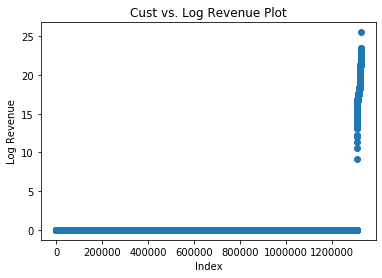

%Customers with Non-Zero revenue:  1.219357421830736


In [6]:
cust_rev_logsum = df_train.groupby('fullVisitorId', as_index=False).agg({'totals.transactionRevenue':'sum'}).rename(columns = {'totals.transactionRevenue':'Revenue_Sum'})
cust_rev_logsum['log_Revenue'] = np.log1p(cust_rev_logsum['Revenue_Sum']) #Since our output label is finally log of predicted sum of revenue

#Visualization
plt.scatter(list(range(cust_rev_logsum.shape[0])), list(np.sort(cust_rev_logsum['log_Revenue'])))
plt.xlabel('Index')
plt.ylabel('Log Revenue')
plt.title('Cust vs. Log Revenue Plot')
plt.show()

print("%Customers with Non-Zero revenue: ", (cust_rev_logsum[cust_rev_logsum.Revenue_Sum>0].shape[0]/cust_rev_logsum.shape[0])*100)

**Observation**

*As per the 80-20 rule, only 20% percent of customers contribute to 80% of the revenue. Which we can see true in our case and the percentage is even less.*

*[%Cust(zero-revenue) : %Cust(non_zero-revenue)] = [98.79:1.21]*

*Out of 1323730 unique customers in our train set, only approx 1.2% customers have non-zero revenue hence majority of the customers have zero revenue. Therefore it is important for us to correctly identify these important customers who contribute to non-zero revenue.*

**Verify 80-20 rule over non-zero revenue customers**

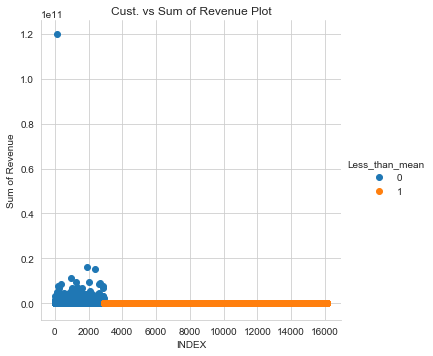

%Customers with revenue less than mean of non-zero revenue:  82.08289449228673
%Contribution of amount by these 82% customers:  26.676668429587718
Outlier Customer fullVisitorId:  1957458976293878100


In [7]:
cust_rev_logsum_nonzero = cust_rev_logsum[cust_rev_logsum.Revenue_Sum!=0].reset_index(drop= True) #Filtering for non_zero revenue customers
mean_nonzero = cust_rev_logsum_nonzero['Revenue_Sum'].mean() 
cust_rev_logsum_nonzero['Less_than_mean'] = cust_rev_logsum_nonzero['Revenue_Sum'].apply(lambda x:1 if x<mean_nonzero else 0)
cust_rev_logsum_nonzero = cust_rev_logsum_nonzero.sort_values(by = 'Less_than_mean').reset_index(drop=True)
cust_rev_logsum_nonzero['INDEX'] = cust_rev_logsum_nonzero.index

#Visualization
sns.set_style("whitegrid");
sns.FacetGrid(cust_rev_logsum_nonzero, hue="Less_than_mean", height=5) \
   .map(plt.scatter, "INDEX", "Revenue_Sum") \
   .add_legend()

plt.title("Cust. vs Sum of Revenue Plot")
plt.ylabel("Sum of Revenue")
plt.show()

print("%Customers with revenue less than mean of non-zero revenue: ", 100*(cust_rev_logsum_nonzero[cust_rev_logsum_nonzero.Less_than_mean==1].shape[0]/cust_rev_logsum_nonzero.shape[0]))
print("%Contribution of amount by these 82% customers: ", 100*(cust_rev_logsum_nonzero[cust_rev_logsum_nonzero.Less_than_mean==1]['Revenue_Sum'].sum()/cust_rev_logsum_nonzero['Revenue_Sum'].sum()))
print("Outlier Customer fullVisitorId: ", cust_rev_logsum_nonzero[cust_rev_logsum_nonzero.Revenue_Sum==cust_rev_logsum_nonzero.Revenue_Sum.max()]['fullVisitorId'].values[0])

**Observation**

*1) Amongst the non-zero revenue customers, we can see from plot that major portion have revenue less than the mean and only small portion have revenue greater than the mean of non-zero revenue across customers.*

*2) To be precise, approx 82% of customers among non_zero revenue contribute less than the mean and therefore only approx 18% of customers contribute more than the mean of non-zero revenue across customers.*

*3) Therefore 82% non_zero revenue customers contribute approx 26% of total reveue. Hence, 80-20 rule is verified in this case too.*

*4) Amongst non_zero revenue customers:*

[%Cust with revenue(less than mean) : %Cust with revenue(greater than mean)] = [82.08 : 17.92]

[%Revenue by 82.08% Cust : %Revenue by 17.92% Cust] = [26.67 : 73.33]

*5) Also another intresting finding from this plot is one of the customers with fullVisitorId=1957458976293878100, has contributed much more in revenue sum than others.*



**Verify 80-20 rule over cout of all customers occurances**

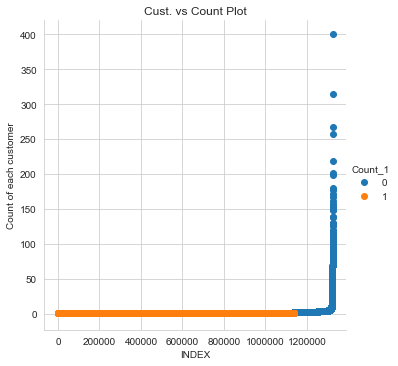

%Customers who only visited only once and more than once respectivey:85.97289477461416 , 14.027105225385839
%Revenue contribution by these 85.97% and 14.02% customers who visited once and more than once respectively:15.813960492188862 , 84.18603950781113


In [8]:
cust_count_df = pd.DataFrame(df_train.fullVisitorId.value_counts()).reset_index().rename(columns={'index':'fullVisitorId', 'fullVisitorId':'count_fullVisitorId'})
cust_count_df['fullVisitorId'] = cust_count_df['fullVisitorId'].astype('str')
df_train = df_train.merge(cust_count_df, on = 'fullVisitorId', how='left')
cust_rev_logsum = cust_rev_logsum.merge(cust_count_df, on = 'fullVisitorId', how='left').sort_values(by = 'count_fullVisitorId').reset_index(drop=True)
cust_rev_logsum['INDEX'] = cust_rev_logsum.index
cust_rev_logsum['Count_1'] = cust_rev_logsum.count_fullVisitorId.apply(lambda x:1 if x==1 else 0)

#Vizualization
sns.set_style("whitegrid");
sns.FacetGrid(cust_rev_logsum, hue="Count_1", height=5) \
   .map(plt.scatter, "INDEX", "count_fullVisitorId") \
   .add_legend()

plt.title("Cust. vs Count Plot")
plt.ylabel("Count of each customer")
plt.show()

print("%Customers who only visited only once and more than once respectivey:{0} , {1}".format((100*(cust_rev_logsum[cust_rev_logsum.Count_1==1].shape[0]/cust_rev_logsum.shape[0])),100-(100*(cust_rev_logsum[cust_rev_logsum.Count_1==1].shape[0]/cust_rev_logsum.shape[0]))))
print("%Revenue contribution by these 85.97% and 14.02% customers who visited once and more than once respectively:{0} , {1}".format((100*cust_rev_logsum[cust_rev_logsum.Count_1==1]['Revenue_Sum'].sum()/cust_rev_logsum['Revenue_Sum'].sum()),100-(100*cust_rev_logsum[cust_rev_logsum.Count_1==1]['Revenue_Sum'].sum()/cust_rev_logsum['Revenue_Sum'].sum())))

**Observation**

*From the plot and above computed percentages, it is clear that major portion of the revenue comes from regular customers and also we have huge majority of one time customers which contribute very little to overall revenue. Hence, in order to correctly forecast for a period we need to correctly predict for both categories especially for regular customers. Also, this statistics follows 80-20 rule to some extent.*

**PDF of Sum of Revenue across customers**

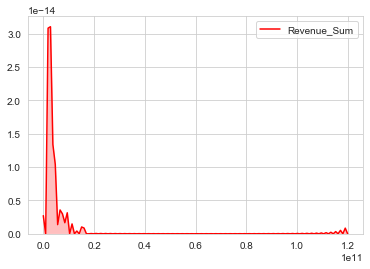

In [9]:
ax = sns.kdeplot(cust_rev_logsum['Revenue_Sum'], shade=True, color="r")

**Observation**

*We have a clear right-skewed distribution in case of totals.TransactionRevenue where majority of our values are zero.*

**PDF of log of Sum of Revenue across customers**

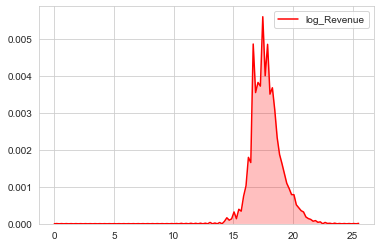

In [10]:
ax = sns.kdeplot(cust_rev_logsum['log_Revenue'], shade=True, color="r")

**Observation**

*By using the log transform values of sum of revenue across customers we are getting comparatively better variance and majority of our values lies in the range 15-22 approximately.*

**Generic vizualization method to explore relation between output variable (totals.transactionRevenue) and a categorical column.**

In [11]:
df_train['Zero_Revenue'] = df_train['totals.transactionRevenue'].apply(lambda x:1 if pd.isnull(x) else 0)#Zero indicator of totals.transactionRevenue

def plot_categorical_variables(categorical_col, x_label, degree=70, font_size=1.5):
    """Generic method to plot/visualize relation between output variable (totals.transactionRevenue) and a categorical column"""
    
    #Mean totals.transactionRevenue for every categorical_col category
    device_gp = df_train.groupby(categorical_col, as_index=False).agg({'totals.transactionRevenue':'mean'}).dropna().reset_index(drop=True)
    #Count of Zero/Non-Zero totals.transactionRevenue for every categorical_col category
    unique_category = device_gp[categorical_col].tolist()
    mask = df_train[categorical_col].apply(lambda x:True if (x in unique_category) else False)
    device_gp_count = df_train[mask].groupby(categorical_col, as_index=False).agg({'Zero_Revenue':['count', 'sum']})
    device_gp_count.columns = [categorical_col, 'Zero_Revenue_count', 'Zero_Revenue_sum']
    device_gp_count['NonZero_Revenue_count'] = np.array(device_gp_count['Zero_Revenue_count'])-np.array(device_gp_count['Zero_Revenue_sum'])

    #Visualization
    fig = plt.figure(figsize=(20,20))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    #1st subplot
    sns.set(font_scale=font_size)
    ax = fig.add_subplot(2, 2, 1)
    sns.set(style="whitegrid")
    plt.xticks(rotation=degree)
    ax = sns.barplot(x=categorical_col, y="totals.transactionRevenue", data=device_gp)
    ax.set(xlabel=x_label, ylabel='Mean Revenue')
    ax.set_title('Plot(b):'+x_label+' vs. Mean Revenue', fontsize=20)

    #2nd subplot
    sns.set(font_scale=font_size)
    ax = fig.add_subplot(2, 2, 2)
    sns.set(style="whitegrid")
    plt.xticks(rotation=degree)
    ax = sns.barplot(x=categorical_col, y="NonZero_Revenue_count", data=device_gp_count)
    ax.set(xlabel=x_label, ylabel='Count of NonZero_Revenue')
    ax.set_title('Plot(c):'+x_label+' vs. Count Non-Zero Revenue', fontsize=20)

    #Plotly subplot
    trace1 = go.Bar(
        x=device_gp_count[categorical_col],
        y=device_gp_count['Zero_Revenue_sum'],
        name='Zero Revenue'
    )
    trace2 = go.Bar(
        x=device_gp_count[categorical_col],
        y=device_gp_count['NonZero_Revenue_count'],
        name='Non-Zero Revenue'
    )

    data = [trace1, trace2]
    layout = go.Layout(barmode='stack')

    ax = go.Figure(data=data, layout=layout)
    ax.update_layout(
        title='Plot(a):Stacked bar plot of ' +x_label+ ' vs Count of Zero/Non-Zero Revenue',
        xaxis_title=x_label,
        yaxis_title="Count",
        font=dict(size=15),
        legend=dict(x=1, y=1, traceorder="normal"))
    ax.show()

**Comments:**

*1) plot_categorical_variables function is a generic function written for this particular use case visualization, where we can pass any categorical column and look at some visualization between that categorical column and Zero/Non-Zero statistics.*

**Exploring relation between totals.transactionRevenue and channelGrouping**

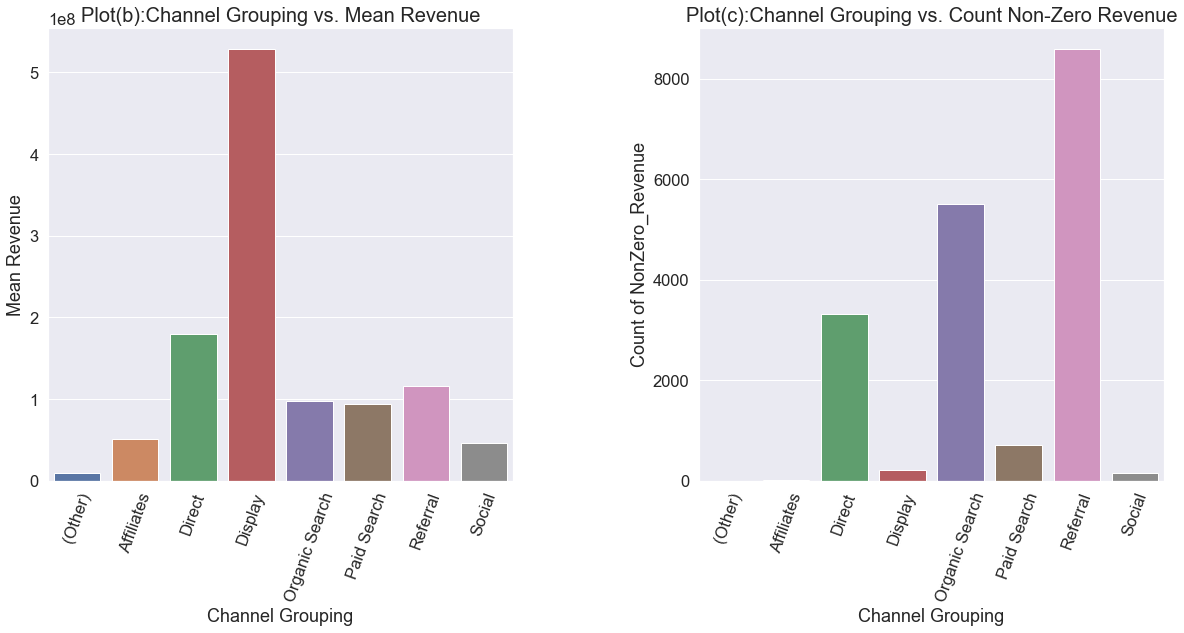

In [12]:
plot_categorical_variables('channelGrouping', 'Channel Grouping')

**Observation**

*1) Plot(a) depicts that we have maximum instances of 'Organic Search' in our dataset followed by 'Social', 'Direct' and 'Referral'. But, from Plot(c) we can conclude that 'Referral' contributes most to Non-Zero revenue instances followed by 'Organic Search' and 'Direct.*

*2) Hence we can see that we do not have directly proportional relation when it comes to count of different Channel Grouping categories and count of Non-Zero count of different Channel Grouping categories.*

*3) Plot(b) depicts that max mean revenue comes from 'Display' category of Channel Grouping column. Hence, we can conclude that there is no relation where we can say that more is the count, more will be revenue.*

*4) On a broader scale; 'Referral', 'Organic Search', 'Display' and 'Direct' categories from Channel Grouping are more important than any other in case of Channel Grouping.*

**Exploring relation between totals.transactionRevenue and device sub features**

*a) Browser*

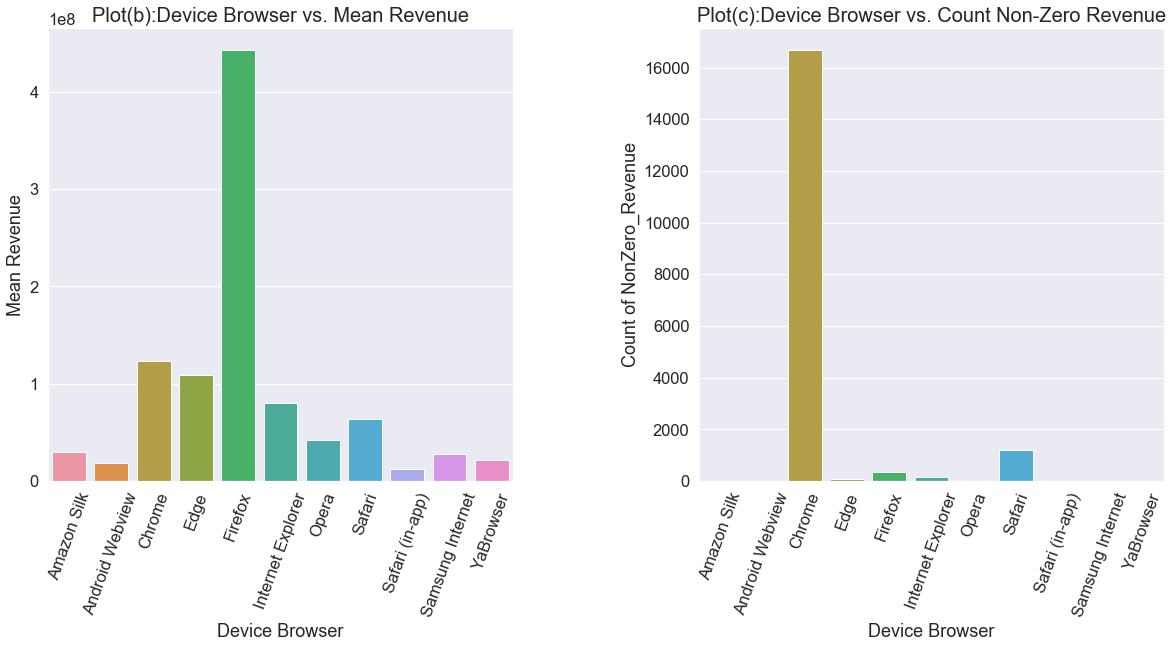

In [13]:
plot_categorical_variables('device.browser', 'Device Browser') #Function call

**Observations**

*1) Plot(a) depicts that we have maximum instances of 'Chrome' in our dataset followed by 'Safari'. Also, from Plot(c) we can conclude that 'Chrome' contributes most to Non-Zero revenue instances followed by 'Safari'*

*2) Hence we can see that we do have directly proportional relation when it comes to count of different Browsers categories and count of Non-Zero count of different Browser categories.*

*3) Plot(b) depicts that max mean revenue comes from 'Firefox' category of Browser column. Hence, we can say that although most of the customers visiting the store both including Zero and Non-Zero revenue generating use Chrome as their browser. But, few of the customers who visited the store via Firefox browser have contributed most in terms of revenue.*

*4) On a broader scale; 'Chrome', 'Firefox', 'Edge' and 'Safari' browsers are more important than any other in case of browser.*

*b) Operating System*

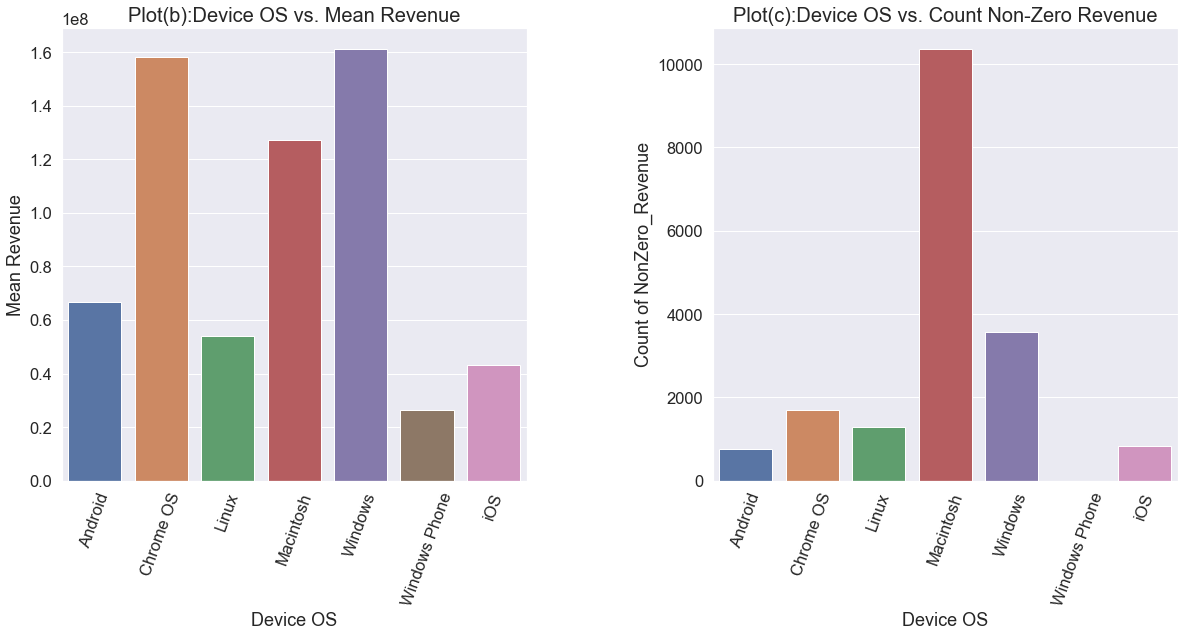

In [14]:
plot_categorical_variables('device.operatingSystem', 'Device OS') #Function call

**Observations**

*1) Plot(a) depicts that we have maximum instances of 'Windows' in our dataset followed by 'Macintosh' and 'Android'. But, from Plot(c) we can conclude that 'Macintosh' contributes most to Non-Zero revenue instances.*

*2) Hence we can conclude that although most of the customers visit the store using Windows OS but one with Macintosh OS are more likely to have Non-Zero transaction.*

*3) Plot(b) depicts that max mean revenue comes from 'Windows' and 'Chrome OS' followed by 'Macintosh' category of Device OS column. Hence, we can say that as a whole Windows and Chrome OS contribute most to revenue followed by 'Macintosh'. Also, surprisingly, 'Chrome OS' has very less instances both Zero and Non-Zero, yet their mean revenue is almost comparable with 'Windows'.*

*4) On a broader scale; 'Windows', 'Macintosh', and 'Chrome OS' operating systems are more important than any other in case of Device OS.*

*c) Category*

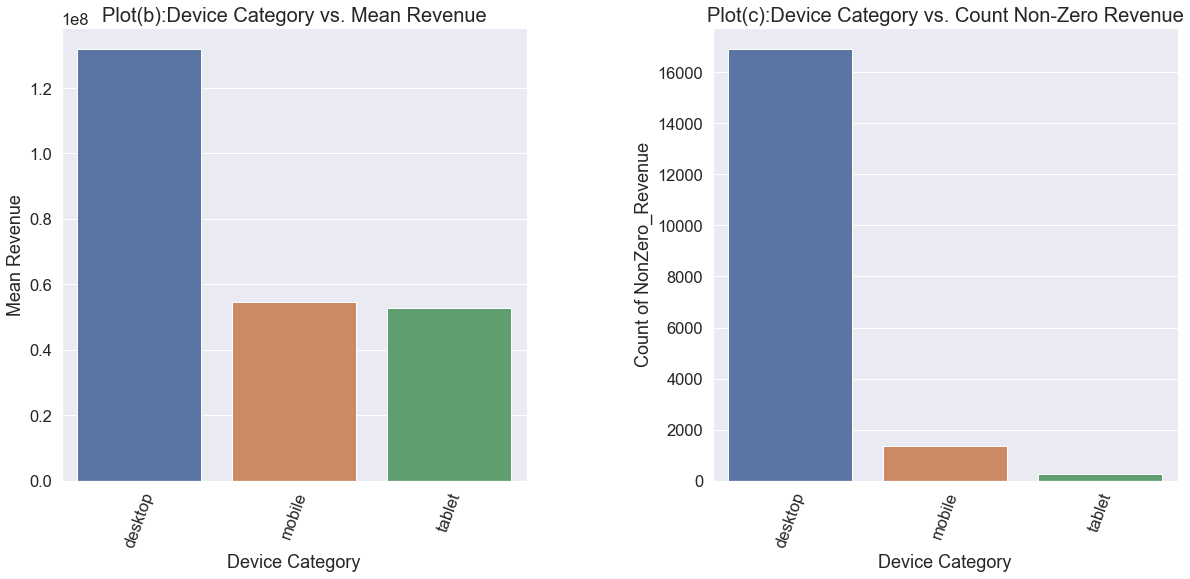

In [15]:
plot_categorical_variables('device.deviceCategory', 'Device Category') #Function call

**Observations**

*1) Plot(a), Plot(b) and Plot(c) here clearly depict that majority of the customers who visit the store, generate majority revenue and have majority of Non-Zero transactions use 'desktop'.*

*2) Also one noteworthy point here is that although 'tablet' has very few instances of both zero and non-zero transactions yet, they generate almost equal mean revenue to 'mobile'.*

**Exploring relation between totals.transactionRevenue and geoNetwork sub features**

a) Continent

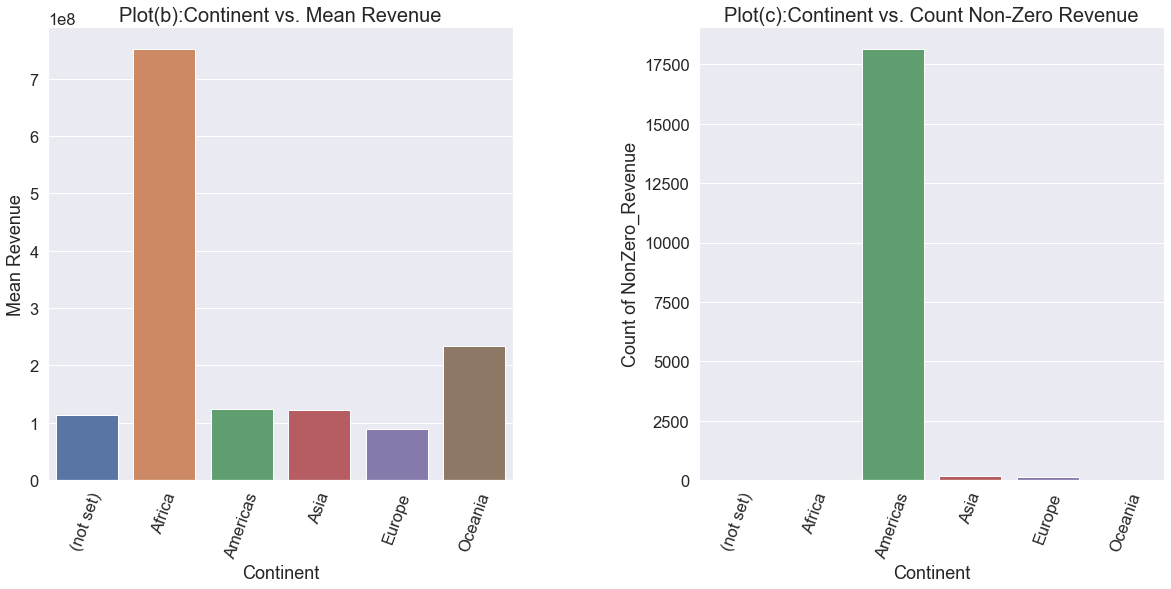

In [16]:
plot_categorical_variables('geoNetwork.continent', 'Continent')

**Observations**

*1) Plot(a) and Plot(c) clearly depicts that huge majority of the customers who visit the store and also have huge majority of Non-Zero transaction instances are from America.*

*2) Surprisingly, Africa has very few instances of transactions both Zero and Non-Zero yet customers from Africa contributes most in terms of mean revenue to the store.*

*b) SubContinent*

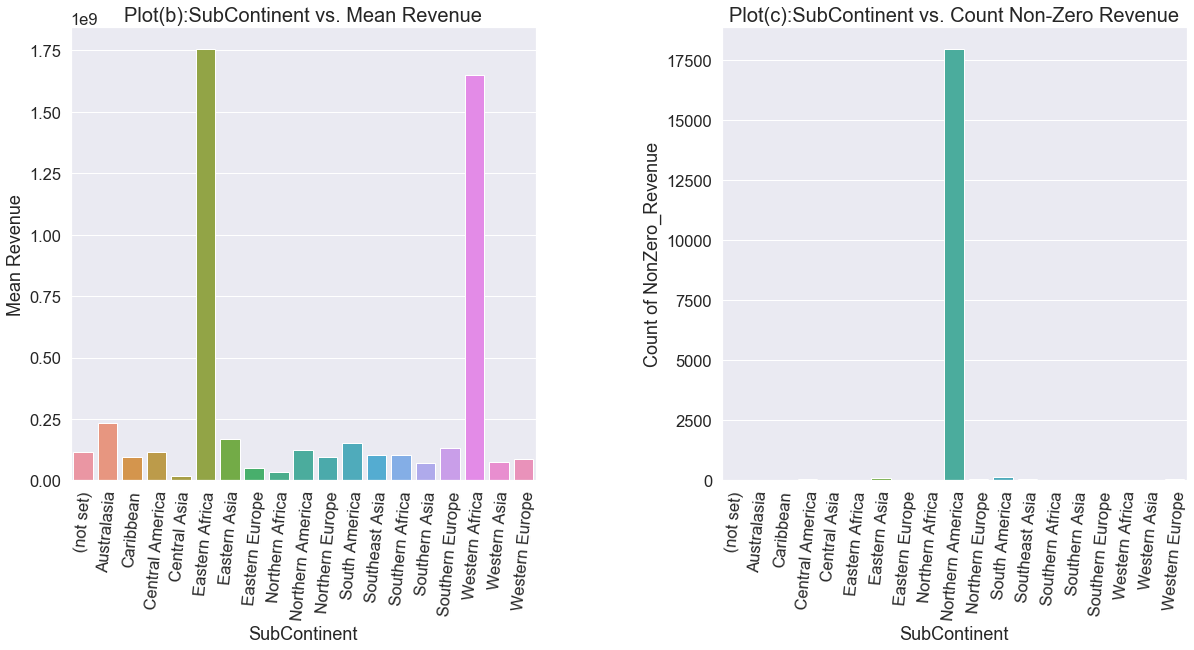

In [17]:
plot_categorical_variables('geoNetwork.subContinent', 'SubContinent', 85)

**Observations**

*1) Plot(a) and Plot(c) both depict that huge majority of the customers who visit the store and also have huge majority of Non-Zero transaction are from North America.*

*2) Plot(c) further gives us information which we concluded in last set of plots that Africa contributes maximum in terms of mean revenue. To be precise, it's Eastern and Western parts of Africa who contibute the most from Africa.*

*c) Metro*

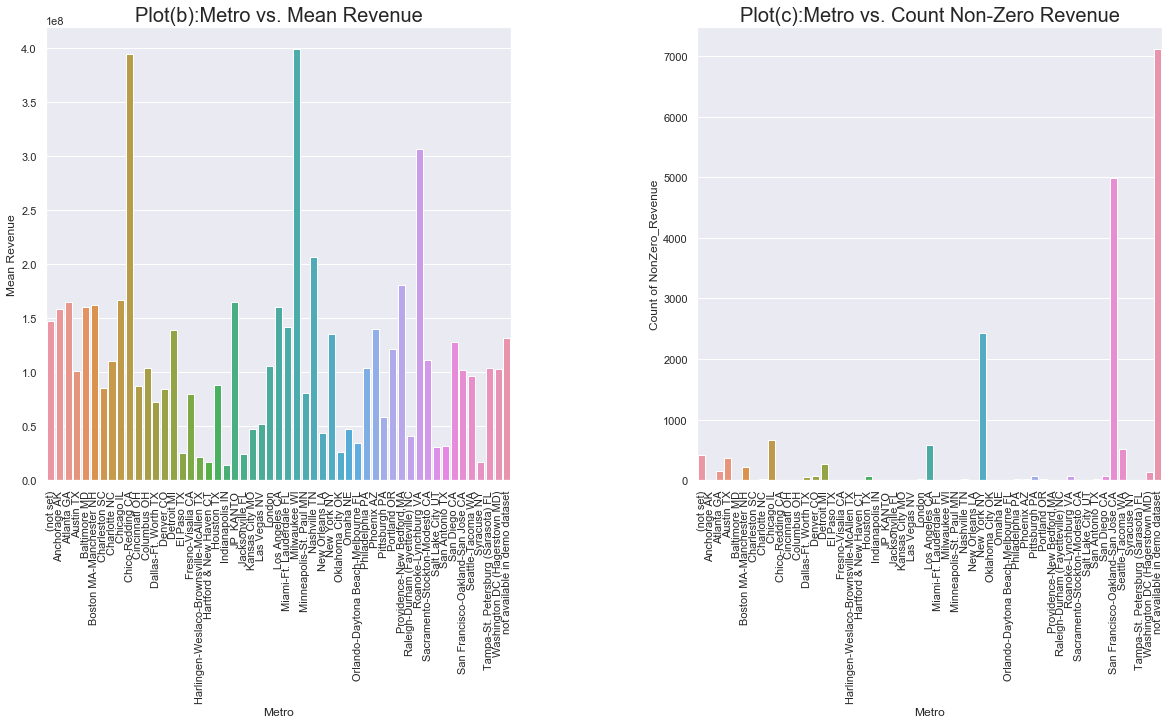

In [18]:
plot_categorical_variables('geoNetwork.metro', 'Metro', 90, 1.0)

**Observations**

*1) Plot(a), Plot(b) and Plot(c) here provides few more insights based on the metro or city of the customers and their corresponding count of transactions and mean of revenue. Amongst, the available metro information, 'Chico-Redding' and 'Milwaukee' which are cities in California district contribute maximum to the mean revenue of the store.*

**Exploring relation between totals.transactionRevenue and totals sub features**

a) Page Views

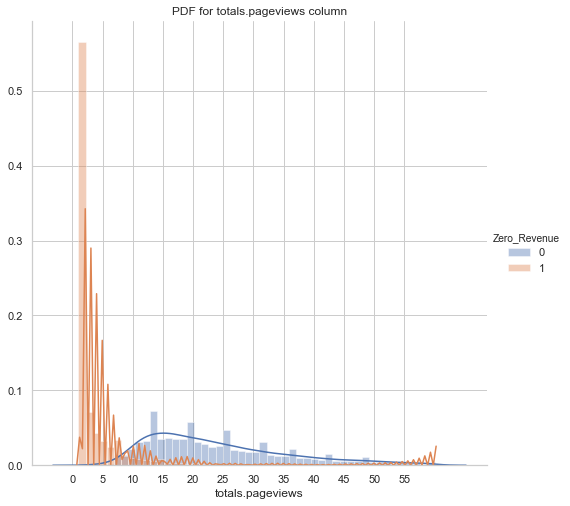

In [19]:
# df_train['Zero_Revenue'] = df_train['totals.transactionRevenue'].apply(lambda x:1 if pd.isnull(x) else 0)#Zero indicator of totals.transactionRevenue

#PDF for totals.pageviews
sns.FacetGrid(df_train[df_train['totals.pageviews']<=60], hue="Zero_Revenue", height=7) \
   .map(sns.distplot, "totals.pageviews") \
   .add_legend()

plt.xticks(np.arange(0, 60, 5))
plt.title("PDF for totals.pageviews column")
plt.show()

**Observation**

*1) From the above plot we can conclude that if number of pageviews are less, customers are more likely to have a empty transaction. Or, another way to put it would be that more is the pageviews, higher is the likelihood that customer will have have a Non-Zero transaction or one can say that he ould be more inclined to buy the product.*

*2) If the pageviews is greater than 10, their is a high likelihood, that customer will have a non-zero transaction for his visit.*

*b) Time on site*

C:\Users\prakhar.raj.HIGHRADIUS\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



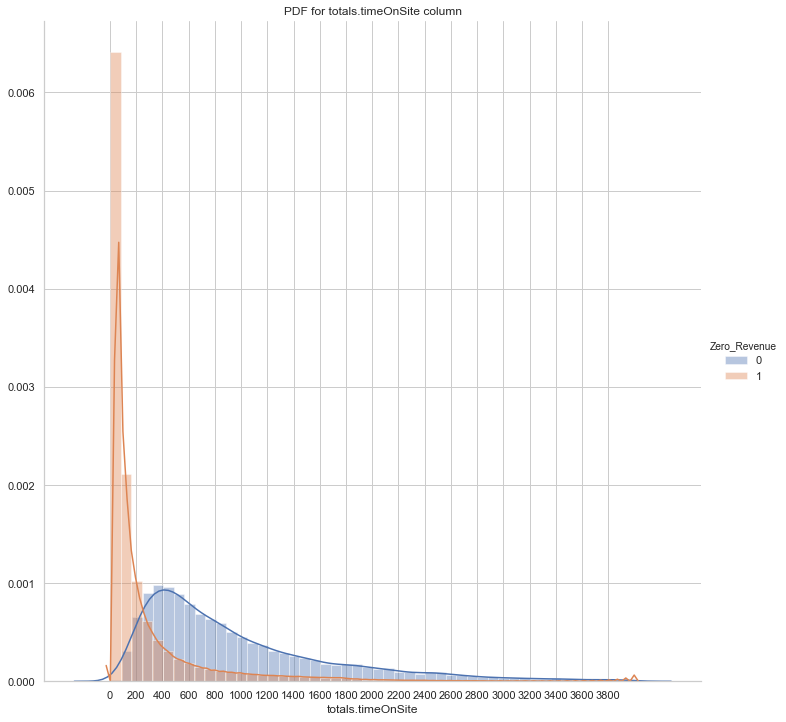

In [20]:
#PDF for totals.timeOnSite
sns.FacetGrid(df_train[df_train['totals.timeOnSite']<=4000], hue="Zero_Revenue", height=5, size=10) \
   .map(sns.distplot, "totals.timeOnSite") \
   .add_legend()

plt.xticks(np.arange(0, 4000, 200))
plt.title("PDF for totals.timeOnSite column")
plt.show()

**Observation**

*1) From the above plot we can derive the inference that more the customer spends time on the site, higher is the likelihood of a non-zero transaction upto a certain point of time.*

*2) Hence, if time spent on site is greater than 300, there is a higher probability that transaction made after that would be a Non-Zero transaction.*

*c) Hits*

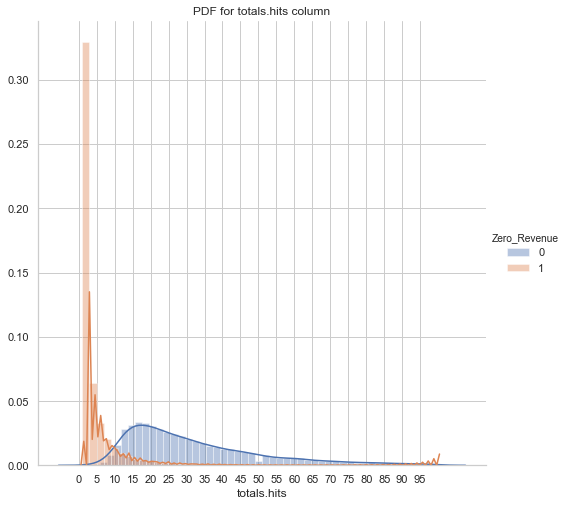

In [21]:
#PDF for totals.hits

sns.FacetGrid(df_train[df_train['totals.hits']<=100], hue="Zero_Revenue", height=7) \
   .map(sns.distplot, "totals.hits") \
   .add_legend()

plt.xticks(np.arange(0, 100, 5))
plt.title("PDF for totals.hits column")
plt.show()

**Observation**

*From the above plot we can derive the conclusion that greater is the hits, higher is the likelihood of a non-zero transaction.
As per this data, if hits > 10, we have a greater likelihood of having a non-zero transaction from the customer.*

*d) Session Quality Dim*

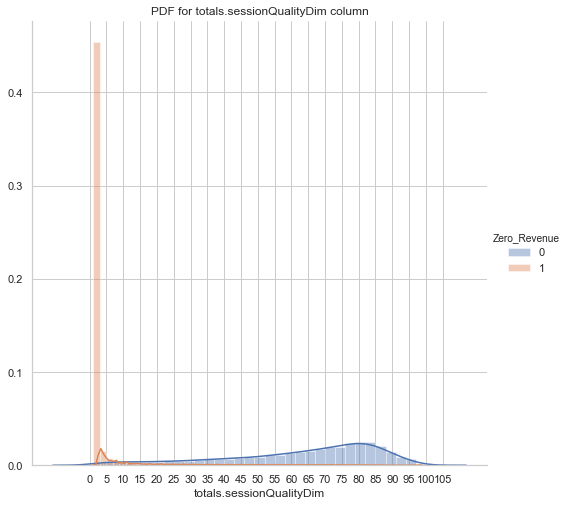

In [22]:
#PDF for totals.sessionQualityDim
sns.FacetGrid(df_train[df_train['totals.sessionQualityDim']<=110], hue="Zero_Revenue", height=7) \
   .map(sns.distplot, "totals.sessionQualityDim") \
   .add_legend()

plt.xticks(np.arange(0, 110, 5))
plt.title("PDF for totals.sessionQualityDim column")
plt.show()

**Observation**

*We seem to have quite a clear distinction of zero and non-zero transactions using sessionQualityDim information. As the value of sessionQualityDim gradually increases, chances of having a non-zero transaction also increases.*

**Exploring relation between totals.transactionRevenue and trafficSource sub features**

*a) Source* 

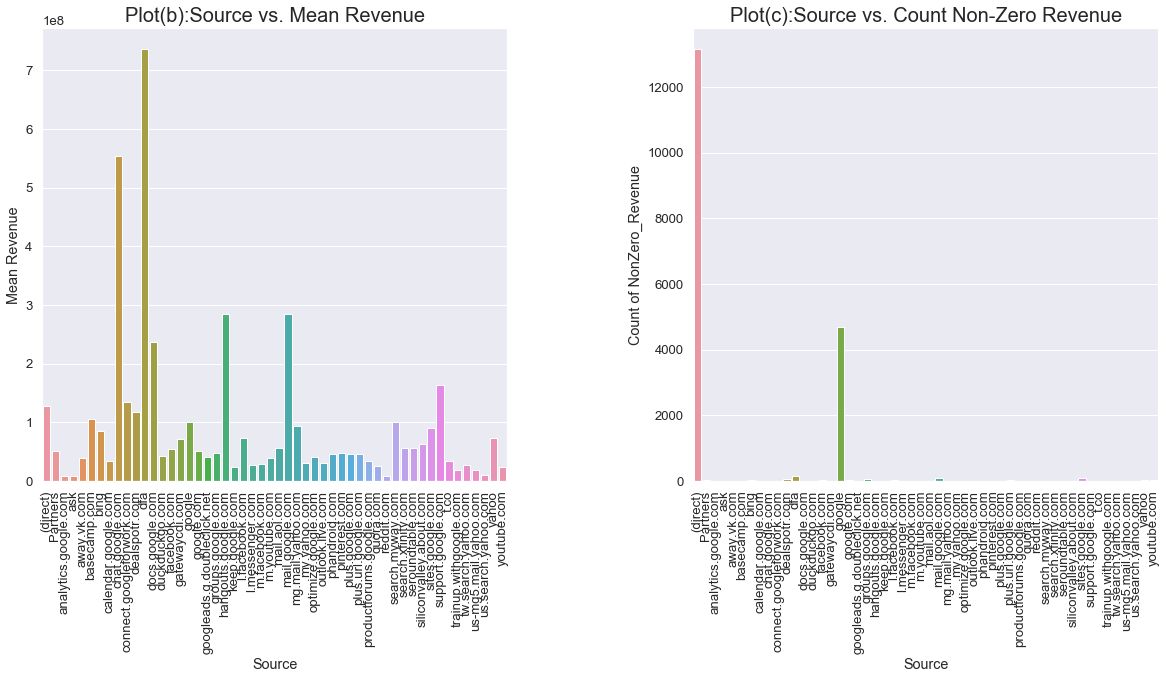

In [23]:
plot_categorical_variables('trafficSource.source', 'Source', 90, 1.2)

**Observation**

*1) Plot(a) depicts that majority of the traffic is routed from 'google' followed by '(direct)' source.*

*2) Also plot(c) depicts that majority of non-zero transactions appear when the customer visits the store directly followed by a good amount of time when routed from 'google'.*

*3) Plot(b) depicts that dfa and google along with it's various products contributes maximum to the mean revenue of the store.*

*b) Medium*

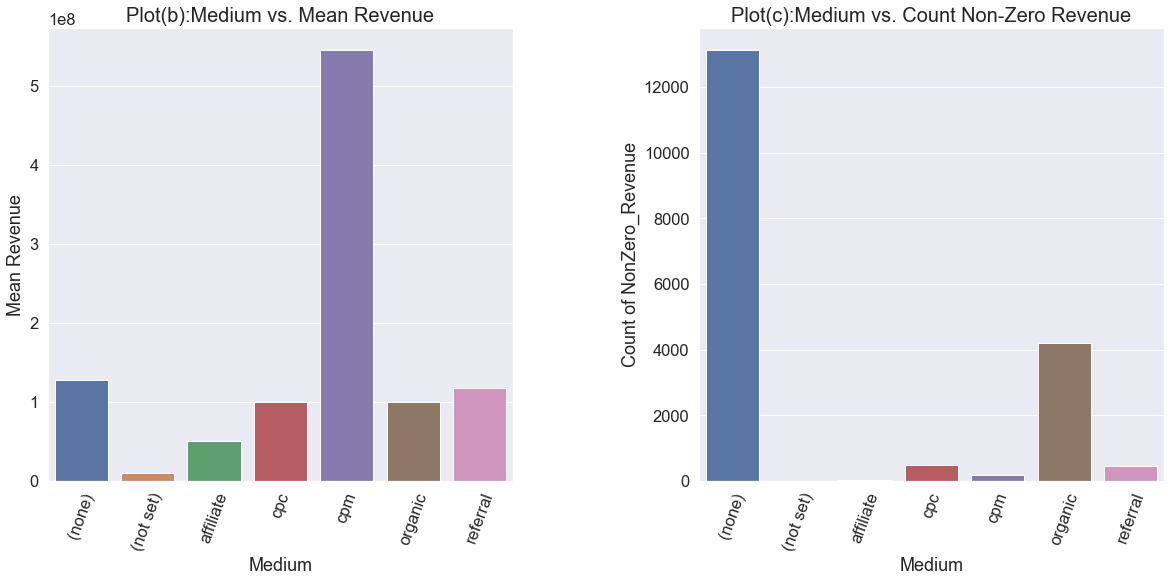

In [24]:
plot_categorical_variables('trafficSource.medium', 'Medium')

**Observation**

*1) Plot(a) suggests that maximum of the values are (none) when it comes to traffic source medium, but out of the populated values, 'organic' and 'referral' contributes most in terms of transaction instances.*

*2) Plot(b) suggests that most of the non-zero transactions come from 'organic' category out of the ones that are populated.*

*3) Plotc(c) suggests that although 'cpm' has lesser transaction instances but has maximum mean revenue contribution for the store.*

**Exploring temporal behaviour of the data using date and totals.transactionRevenue**

In [25]:
#Populating date - time related details which will help us in visualization

time_df = df_train[['date', 'fullVisitorId', 'totals.transactionRevenue']].reset_index(drop=True)
time_df['date'] = pd.to_datetime(time_df['date'], format="%Y%m%d")
time_df['Day'] = time_df['date'].dt.day
time_df['Month'] = time_df['date'].dt.month
time_df['Year'] = time_df['date'].dt.year
time_df['DOW'] = time_df['date'].dt.dayofweek

In [26]:
gp_time = time_df.groupby('Day', as_index=False).agg({'totals.transactionRevenue':'sum'}).rename(columns = {'totals.transactionRevenue':'Day_Sum'})
fig = px.bar(gp_time, x='Day', y='Day_Sum')
fig.update_layout(
        title='Plot(a):Bar plot of Day vs Sum of Revenue',
        title_x=0.5,
        xaxis_title='Day',
        yaxis_title="Sum of Revenue",
        font=dict(size=15),
        legend=dict(x=1, y=1, traceorder="normal"))
fig.show()



**Observations**

*1) The above plot suggests that maximum revenue of the store is earned in the 12th to 18th days of the month with some spikes on some days in the start and the end of the month.*

In [27]:
gp_time = time_df.groupby('Month', as_index=False).agg({'totals.transactionRevenue':'sum'}).rename(columns = {'totals.transactionRevenue':'Month_Sum'})
fig = px.bar(gp_time, x='Month', y='Month_Sum')
fig.update_layout(
        title='Plot(b):Bar plot of Month vs Sum of Revenue',
        title_x=0.5,
        xaxis_title='Month',
        yaxis_title="Sum of Revenue",
        font=dict(size=15),
        legend=dict(x=1, y=1, traceorder="normal"))
fig.show()

**Observations**

*The above plot sugests that maximum revenue of the store comes in the month of August followed by April and September. Whereas in the months of May-July, the sales are all time low across the dataset.*

In [28]:
gp_time = time_df.groupby('DOW', as_index=False).agg({'totals.transactionRevenue':'sum'}).rename(columns = {'totals.transactionRevenue':'DOW_Sum'})
fig = px.bar(gp_time, x='DOW', y='DOW_Sum')
fig.update_layout(
        title='Plot(c):Bar plot of Day of Week vs Sum of Revenue',
        title_x=0.5,
        xaxis_title='Day of Week',
        yaxis_title="Sum of Revenue",
        font=dict(size=15),
        legend=dict(x=1, y=1, traceorder="normal"))
fig.show()

**Observations**

*The above plot suggests that maximum revenue for the store is earned during the working days with a maximum of revenue of Wednesday followed by Tuesday and Monday and all time low on Saturday and Sunday. Which also makes sense that as it is an online store and people tend to go out on weekends and hence majority of the sales comes on working days when people have their electronic devices(eg. mobile, tablet and desktop) handy.*

In [29]:
gp_time_2016 = time_df[time_df['Year']==2016].sort_values(by='date').reset_index(drop=True).groupby('date', as_index=False).agg({'totals.transactionRevenue':'sum'}).rename(columns = {'totals.transactionRevenue':'Date_Sum'})
gp_time_2016['date'] = gp_time_2016['date'].apply(lambda x: x.replace(2017))
gp_time_2017 = time_df[time_df['Year']==2017].sort_values(by='date').reset_index(drop=True).groupby('date', as_index=False).agg({'totals.transactionRevenue':'sum'}).rename(columns = {'totals.transactionRevenue':'Date_Sum'})
gp_time_2018 = time_df[time_df['Year']==2018].sort_values(by='date').reset_index(drop=True).groupby('date', as_index=False).agg({'totals.transactionRevenue':'sum'}).rename(columns = {'totals.transactionRevenue':'Date_Sum'})
gp_time_2018['date'] = gp_time_2018['date'].apply(lambda x: x.replace(2017))

fig = go.Figure()
fig.add_trace(go.Scatter(
                x=gp_time_2016['date'],
                y=gp_time_2016['Date_Sum'],
                name="2016",
                line_color='orange',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=gp_time_2017['date'],
                y=gp_time_2017['Date_Sum'],
                name="2017",
                line_color='blue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=gp_time_2018['date'],
                y=gp_time_2018['Date_Sum'],
                name="2018",
                line_color='red',
                opacity=0.8))

fig.update_layout(title='Plot(d):Time Series plot of Date vs Sum of Revenue',
                title_x=0.5,
                xaxis=dict(tickformat="%B"),
                xaxis_range=['2017-01-01','2017-12-31'],
                xaxis_title='Date',
                yaxis_title="Sum of Revenue",
                font=dict(size=15),
                legend=dict(x=1, y=1, traceorder="normal"))
fig.show()

**Observations**

*1) From the above plot we can make the inference that the revenue over years has decreased from 2016 to 2018 over period of time for which the data is available.*

*2) For the months of August-December, we see more peaks in 2016 in comparison to 2017 which suggests that revenue generation was better for atleast these months in 2016 than 2017.*

*3) Same goes for months of January-April, revenue generation in 2017 was more in comparison to 2018 which again proves the assumption that revenue generation is gradually decreasing over the years atleast for the months we have data to perform comparison.*

*4) Although for the months of May-July we have data from one year only but still peaks suggest that those months also has some good revenue generation atleast for the year of 2017.*

In [30]:
gp_time_2016 = time_df[(time_df['Year']==2016) & (~pd.isnull(time_df['totals.transactionRevenue']))].sort_values(by='date').reset_index(drop=True).groupby('date', as_index=False).agg({'totals.transactionRevenue':'count'}).rename(columns = {'totals.transactionRevenue':'Date_NonZero_Count'})
gp_time_2016['date'] = gp_time_2016['date'].apply(lambda x: x.replace(2017))
gp_time_2018 = time_df[(time_df['Year']==2018) & (~pd.isnull(time_df['totals.transactionRevenue']))].sort_values(by='date').reset_index(drop=True).groupby('date', as_index=False).agg({'totals.transactionRevenue':'count'}).rename(columns = {'totals.transactionRevenue':'Date_NonZero_Count'})
gp_time_2018['date'] = gp_time_2018['date'].apply(lambda x: x.replace(2017))
gp_time_2017 = time_df[(time_df['Year']==2017) & (~pd.isnull(time_df['totals.transactionRevenue']))].sort_values(by='date').reset_index(drop=True).groupby('date', as_index=False).agg({'totals.transactionRevenue':'count'}).rename(columns = {'totals.transactionRevenue':'Date_NonZero_Count'})

fig = go.Figure()
fig.add_trace(go.Scatter(
                x=gp_time_2016['date'],
                y=gp_time_2016['Date_NonZero_Count'],
                name="2016",
                line_color='orange',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=gp_time_2017['date'],
                y=gp_time_2017['Date_NonZero_Count'],
                name="2017",
                line_color='blue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=gp_time_2018['date'],
                y=gp_time_2018['Date_NonZero_Count'],
                name="2018",
                line_color='red',
                opacity=0.8))

fig.update_layout(title='Plot(e):Time Series plot of Date vs Non Zero Revenue Count',
                title_x=0.5,
                xaxis=dict(tickformat="%B"),
                xaxis_range=['2017-01-01','2017-12-31'],
                xaxis_title='Date',
                yaxis_title="Non Zero Revenue Count",
                font=dict(size=15),
                legend=dict(x=1, y=1, traceorder="normal"))
fig.show()

**Observations**

*1) Plot(e) depicts the count of Non-Zero transactions on each date over a period of 2016-2018. It is along the same lines that we saw in Plot(d). The revenue generation and hence the count of Non-Zero transactions over the year have reduced.*

*2) As we can see for the months of August-December clearly, count of Non-Zero transactions were much more in 2016 in comparison to 2017 with clear spikes in the later months of November and December.*

*3) Also during the months of January-April, 2017 has more number of Non-Zero transactions in comparison to 2018 for the same months with an exception of later parts of March where in 2018 we have abnormal spikes in data which suggests some sort of a sale or an event that attracted a lot of customers and also they made lots of Non-Zero transactions.*

<h1>Data Preparation Methods<h1>

In [31]:
def generate_output(fullData):
    """1) Divide the entire data into 4 set (3 for training and 1 for validation) 2) Also, populate output labels in all 4 sets"""
    
    #List of dates for dividing whole data in 4 sets with configuration of final train and test i.e. each training set is of 168
    #days and output variable calculation is from a period of 62 days with a gap of 46 days in between
    train_set_start = ['2016-08-01', '2017-01-16',  '2017-07-03', '2017-12-18']
    train_set_end = ['2017-01-16', '2017-07-03', '2017-12-18', '2018-06-04']
    output_start = ['2017-03-03', '2017-08-18', '2018-02-02', '2018-07-20']
    output_end = ['2017-05-04', '2017-10-19', '2018-04-05', '2018-09-20']
    #Converting above dates to timestamp object
    train_set_start = [pd.to_datetime(each) for each in train_set_start]
    train_set_end = [pd.to_datetime(each) for each in train_set_end]
    output_start = [pd.to_datetime(each) for each in output_start]
    output_end = [pd.to_datetime(each) for each in output_end]

    list_of_dfs = []

    for i in range(4):
        train_set_df = fullData[(fullData.date >= train_set_start[i]) & (fullData.date < train_set_end[i])].reset_index(drop=True)
        output_set_df = fullData[(fullData.date >= output_start[i]) & (fullData.date < output_end[i])].reset_index(drop=True)
        returned_customers = list(set(train_set_df.fullVisitorId.unique()).intersection(set(output_set_df.fullVisitorId.unique())))
        #Populating output label for classification task
        train_set_df['RETURN'] = 0
        train_set_df['RETURN'] = train_set_df['fullVisitorId'].apply(lambda x:1 if (x in returned_customers) else 0)
        #Populating output column for regression task i.e. log of sum of revenue by customers
        gp_log = output_set_df.groupby('fullVisitorId', as_index=False).agg({'totals.transactionRevenue':'sum'}).rename(columns={'totals.transactionRevenue':'REVENUE'})
        gp_log['REVENUE'] = np.log1p(gp_log['REVENUE'])
        train_set_df = train_set_df.merge(gp_log, on='fullVisitorId', how='left').reset_index(drop=True)
        print("Date Range of Train_Set_{0} is {1} to {2}".format(i+1, train_set_df.date.min().date(), train_set_df.date.max().date()))
        list_of_dfs.append(train_set_df)

    return list_of_dfs[0], list_of_dfs[1], list_of_dfs[2], list_of_dfs[3] 

<h1>Feature Engineering<h1>

In [32]:
def generate_features(train_set):
    """Generate feature set for preprocessed data passed to this method"""
    
    feature_list = []
    
    #First_Session
    min_date = train_set['date'].min().date()
    gp_feature = train_set[['fullVisitorId', 'date']].groupby('fullVisitorId', as_index=False).agg({'date':'min'})
    gp_feature['First_Session'] = gp_feature['date'].apply(lambda x: (x.date() - min_date).days)
    train_set = train_set.merge(gp_feature[['fullVisitorId', 'First_Session']], on='fullVisitorId', how='left')
    feature_list.append('First_Session')
    
    #Last_Session
    max_date = train_set['date'].max().date()
    gp_feature = train_set[['fullVisitorId', 'date']].groupby('fullVisitorId', as_index=False).agg({'date':'max'})
    gp_feature['Last_Session'] = gp_feature['date'].apply(lambda x: (max_date - x.date()).days)
    train_set = train_set.merge(gp_feature[['fullVisitorId', 'Last_Session']], on='fullVisitorId', how='left')
    feature_list.append('Last_Session')
    
    #Unique_Date
    gp_feature = train_set.groupby(by='fullVisitorId', as_index=False).agg({'date': pd.Series.nunique}).rename(columns={'date':'Unique_Date'})
    train_set = train_set.merge(gp_feature, on='fullVisitorId', how='left')
    feature_list.append('Unique_Date')
    
    #Max_Visit
    gp_feature = train_set.groupby('fullVisitorId', as_index=False).agg({'visitNumber':'max'}).rename(columns={'visitNumber':'Max_Visit'})
    train_set = train_set.merge(gp_feature, on='fullVisitorId', how='left')
    feature_list.append('Max_Visit')
    
    #isMobile
    train_set['isMobile'] = train_set['device.isMobile'].apply(lambda x:1 if x else 0)
    gp_feature = train_set.groupby('fullVisitorId', as_index=False).agg({'isMobile':'mean'}).rename(columns={'isMobile':'isMobile_mean'})
    train_set = train_set.merge(gp_feature, on='fullVisitorId', how='left')
    feature_list.append('isMobile_mean')
    
    #hits statistics
    gp_feature = train_set.groupby('fullVisitorId', as_index=False).agg({'totals.hits':['sum', 'mean', 'min', 'max', 'median', np.std]})
    gp_feature.columns = ['fullVisitorId', 'hits_sum', 'hits_mean', 'hits_min', 'hits_max', 'hits_median', 'hits_std']
    gp_feature = gp_feature.fillna(0)
    train_set = train_set.merge(gp_feature, on='fullVisitorId', how='left')
    feature_list.extend(['hits_sum', 'hits_mean', 'hits_min', 'hits_max', 'hits_median', 'hits_std'])
    
    #pageviews statistics
    gp_feature = train_set.groupby('fullVisitorId', as_index=False).agg({'totals.pageviews':['sum', 'mean', 'min', 'max', 'median', np.std]})
    gp_feature.columns = ['fullVisitorId', 'pageviews_sum', 'pageviews_mean', 'pageviews_min', 'pageviews_max', 'pageviews_median', 'pageviews_std']
    gp_feature = gp_feature.fillna(0)
    train_set = train_set.merge(gp_feature, on='fullVisitorId', how='left')
    feature_list.extend(['pageviews_sum', 'pageviews_mean', 'pageviews_min', 'pageviews_max', 'pageviews_median', 'pageviews_std'])
    
    #transaction statistics
    gp_feature = train_set.groupby('fullVisitorId', as_index=False).agg({'totals.transactionRevenue':'sum', 'totals.transactions':'sum'}).rename(columns={'totals.transactionRevenue':'Rev_Sum', 'totals.transactions':'Trans_Sum'})
    train_set = train_set.merge(gp_feature, on='fullVisitorId', how='left')
    feature_list.extend(['Rev_Sum', 'Trans_Sum'])
    
    #Session_Count
    gp_feature = train_set.groupby('fullVisitorId', as_index=False).agg({'visitStartTime':'count'}).rename(columns={'visitStartTime':'Session_Count'})
    train_set = train_set.merge(gp_feature, on='fullVisitorId', how='left')
    feature_list.append('Session_Count')
    
    ##Categorical feature
    #channelGrouping
    gp_feature = train_set.groupby('fullVisitorId', as_index=False).agg({'channelGrouping': stats.mode})
    gp_feature['channelGrouping_max_cat'] = gp_feature['channelGrouping'].apply(lambda x: x[0][0])
    gp_feature['channelGrouping_max_cat_count'] = gp_feature['channelGrouping'].apply(lambda x: x[1][0])
    gp_feature = gp_feature[['fullVisitorId', 'channelGrouping_max_cat', 'channelGrouping_max_cat_count']]
    train_set = train_set.merge(gp_feature, on='fullVisitorId', how='left')
    feature_list.append('channelGrouping_max_cat_count')
    
    #networkDomain
    gp_feature = train_set.groupby('fullVisitorId', as_index=False).agg({'geoNetwork.networkDomain': stats.mode})
    gp_feature['networkDomain_max_cat'] = gp_feature['geoNetwork.networkDomain'].apply(lambda x: x[0][0])
    gp_feature['networkDomain_max_cat_count'] = gp_feature['geoNetwork.networkDomain'].apply(lambda x: x[1][0])
    gp_feature = gp_feature[['fullVisitorId', 'networkDomain_max_cat', 'networkDomain_max_cat_count']]
    train_set = train_set.merge(gp_feature, on='fullVisitorId', how='left')
    feature_list.append('networkDomain_max_cat_count')
    
    #browser
    gp_feature = train_set.groupby('fullVisitorId', as_index=False).agg({'device.browser': stats.mode})
    gp_feature['browser_max_cat'] = gp_feature['device.browser'].apply(lambda x: x[0][0])
    gp_feature['browser_max_cat_count'] = gp_feature['device.browser'].apply(lambda x: x[1][0])
    gp_feature = gp_feature[['fullVisitorId', 'browser_max_cat', 'browser_max_cat_count']]
    train_set = train_set.merge(gp_feature, on='fullVisitorId', how='left')
    feature_list.append('browser_max_cat_count')
    
    #city
    gp_feature = train_set.groupby('fullVisitorId', as_index=False).agg({'geoNetwork.city': stats.mode})
    gp_feature['city_max_cat'] = gp_feature['geoNetwork.city'].apply(lambda x: x[0][0])
    gp_feature['city_max_cat_count'] = gp_feature['geoNetwork.city'].apply(lambda x: x[1][0])
    gp_feature = gp_feature[['fullVisitorId', 'city_max_cat', 'city_max_cat_count']]
    train_set = train_set.merge(gp_feature, on='fullVisitorId', how='left')
    feature_list.append('city_max_cat_count')
    
    #metro
    gp_feature = train_set.groupby('fullVisitorId', as_index=False).agg({'geoNetwork.metro': stats.mode})
    gp_feature['metro_max_cat'] = gp_feature['geoNetwork.metro'].apply(lambda x: x[0][0])
    gp_feature['metro_max_cat_count'] = gp_feature['geoNetwork.metro'].apply(lambda x: x[1][0])
    gp_feature = gp_feature[['fullVisitorId', 'metro_max_cat', 'metro_max_cat_count']]
    train_set = train_set.merge(gp_feature, on='fullVisitorId', how='left')
    feature_list.append('metro_max_cat_count')
    
    #region
    gp_feature = train_set.groupby('fullVisitorId', as_index=False).agg({'geoNetwork.region': stats.mode})
    gp_feature['region_max_cat'] = gp_feature['geoNetwork.region'].apply(lambda x: x[0][0])
    gp_feature['region_max_cat_count'] = gp_feature['geoNetwork.region'].apply(lambda x: x[1][0])
    gp_feature = gp_feature[['fullVisitorId', 'region_max_cat', 'region_max_cat_count']]
    train_set = train_set.merge(gp_feature, on='fullVisitorId', how='left')
    feature_list.append('region_max_cat_count')
    
    return train_set, feature_list

<h1>Modelling<h1>

**Batch Wise Training Of Classification Model using Random Forest Classifier**

In [33]:
def RF_Classifier(consolidated_train, validation_set):
    """Train ensemble of 152 Random Forest classifiers"""

    start_time = time.time()
    consolidated_train_0 = consolidated_train[consolidated_train.RETURN==0].reset_index(drop=True)
    consolidated_train_1 = consolidated_train[consolidated_train.RETURN==1].reset_index(drop=True)
    y_pred_classifier_list = []
    model_save_list = []
    num_samples_0 = consolidated_train_1.shape[0]

    start = 0
    index_set = set(range(consolidated_train_0.shape[0]))

    for i in tqdm(range(int(np.ceil(consolidated_train_0.shape[0]/consolidated_train_1.shape[0])))):

        #Randomly select 6879 rows from the subset of data consisting only 0 as value for 'RETURN' o/p variable
        if (i==int(np.ceil(consolidated_train_0.shape[0]/consolidated_train_1.shape[0])-1)):
            index_range = list(index_set)
        else:
            index_range = random.sample(index_set, num_samples_0)

        index_set.difference_update(set(index_range)) #Sampling without replacement

        #Preparing sample data with equal instances of 0's and 1's for RETURN output variable
        full_sample = pd.concat([consolidated_train_0.iloc[index_range,:].reset_index(drop=True), consolidated_train_1], axis=0)
        full_sample.reset_index(drop=True, inplace=True)

        ##Classification
        RF_classifer = RandomForestClassifier(random_state=0, n_jobs=-1)

        #Hyperparameter Tuning
        param_dict = {'max_depth': [3,4,5,6,7,9], 'n_estimators' : [40,45,50,55,60,65], 'max_features': ['auto', 'sqrt', 'log2'],
                  'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]}

        RF_random_classifer = RandomizedSearchCV(RF_classifer, param_distributions=param_dict,
                                           n_iter=5,cv=3,scoring='f1',random_state=0, return_train_score=True)

        RF_random_classifer.fit(full_sample.iloc[:,:26].values, full_sample['RETURN'].values)

        #Trainig RandomForestClassifier with best parameter found from RandomizedSearchCV
        RF_classifer = RandomForestClassifier(random_state=0, n_jobs=-1,
                                           n_estimators = RF_random_classifer.best_params_['n_estimators'], 
                                           max_depth = RF_random_classifer.best_params_['max_depth'],
                                           max_features = RF_random_classifer.best_params_['max_features'],
                                           min_samples_leaf = RF_random_classifer.best_params_['min_samples_leaf'],
                                           min_samples_split = RF_random_classifer.best_params_['min_samples_split']
                                           )

        RF_classifer.fit(full_sample.iloc[:,:26].values, full_sample['RETURN'].values)

        y_pred_classifier = RF_classifer.predict(validation_set.iloc[:,:26].values)

        #Saving model and prediction probability
        model_save_list.append(RF_classifer)
        probability_1 = [each[1] for each in RF_classifer.predict_proba(validation_set.iloc[:,:26].values)]

        #y_pred_classifier_list is list of list consiting of prediction probability by ech of 152 models for validation_set
        y_pred_classifier_list.append(probability_1) 

    end_time = time.time()
    RF_time = end_time-start_time
    
    #Reports
    RF_RMSE = np.sqrt(mean_squared_error(validation_set['RETURN'].values, np.array(y_pred_classifier_list).mean(axis=0)))
    
    print("Random Forest Ensemble is trained!")
    return model_save_list, RF_time, RF_RMSE

**Training of Regression Model using LightGBM Regressor**

In [34]:
def LGBM_Regressor(consolidated_train, validation_set):
    """Train LightGBM Regressor"""
    
    start_time = time.time()
    ##Regression
    LGBM_regresor = lgb.LGBMRegressor(random_state=0, n_jobs=-1, objective='regression', metric = "rmse")

    #Hyperparameter Tuning
    param_dict = {'max_depth': [3,4,5,6,7,9], 'n_estimators' : [40,45,50,55,60,65], 'num_leaves' : [29,30,31,32,33],
                  'min_data_in_leaf' : [1,2,3,4,5], 'max_bin' : [256, 260, 265], 'learning_rate':[0.1, 0.01]}

    LGBM_random_regresor = RandomizedSearchCV(LGBM_regresor, param_distributions=param_dict,
                                       n_iter=5,cv=3,scoring='r2',random_state=0, return_train_score=True)

    LGBM_random_regresor.fit(consolidated_train[consolidated_train['RETURN']==1].reset_index(drop=True).iloc[:,:26].values, consolidated_train[consolidated_train['RETURN']==1].reset_index(drop=True)['REVENUE'].values)

    #Trainig LightGBMRegresor with best parameter found from RandomizedSearchCV
    LGBM_regresor = lgb.LGBMRegressor(random_state=0, n_jobs=-1, objective='binary', metric = "binary_logloss",
                                       n_estimators = LGBM_random_regresor.best_params_['n_estimators'],
                                       max_depth = LGBM_random_regresor.best_params_['max_depth'],
                                       num_leaves = LGBM_random_regresor.best_params_['num_leaves'],
                                       min_data_in_leaf = LGBM_random_regresor.best_params_['min_data_in_leaf'],
                                       max_bin = LGBM_random_regresor.best_params_['max_bin'],
                                       learning_rate = LGBM_random_regresor.best_params_['learning_rate']
                                       )

    LGBM_regresor.fit(consolidated_train[consolidated_train['RETURN']==1].reset_index(drop=True).iloc[:,:26].values, consolidated_train[consolidated_train['RETURN']==1].reset_index(drop=True)['REVENUE'].values)

    y_pred_regressor = LGBM_regresor.predict(validation_set.iloc[:,:26].values)
    y_true_regressor = validation_set['REVENUE'].values
    
    #Reports
    LGBM_Reg_RMSE = np.sqrt(mean_squared_error(y_true_regressor, y_pred_regressor))
    end_time = time.time()
    LGBM_Reg_time = end_time-start_time
    
    print("LightGBM Regressor is trained!")

    #Plot feature importance for LGBM Regressor Model
    feat_importances = pd.Series(LGBM_regresor.feature_importances_, index=consolidated_train.columns[:-2])
    plt.figure(figsize=(15,15))
    feat_importances.nlargest(20).plot(kind='barh')
    plt.title('LightGBM Regressor- Feature Importance', fontsize=13)
    plt.xlabel('Feature Importance', fontsize=13)
    plt.ylabel('Features', fontsize=13)
    plt.plot()
    
    return LGBM_regresor, LGBM_Reg_RMSE, LGBM_Reg_time

In [35]:
def model_generation_method (df_train, df_test):
    """Utility method to call classifier and regressor methods and perform training"""
    
    #Merging train and test dataframes and populating time based features in fullData
    print('*'*54 + 'Preparing Full Data' + '*'*54)
    common_columns = list(set(df_train.columns).intersection(set(df_test.columns)))
    fullData = pd.concat([df_train[common_columns], df_test], axis=0)
    fullData['date'] = pd.to_datetime(fullData['date'], format="%Y%m%d")
    fullData = fullData.sort_values(by='date').reset_index(drop=True)
    print("Shape of fullData: ", fullData.shape)
    print("Data is available for date range {0} to {1}".format(fullData['date'].min().date(), fullData['date'].max().date()))
    fullData['Day'] = fullData['date'].dt.day
    fullData['Month'] = fullData['date'].dt.month
    fullData['Year'] = fullData['date'].dt.year
    fullData['DOW'] = fullData['date'].dt.dayofweek
    print('*'*54 + 'Preparing Full Data' + '*'*54)
    
    #Function call to Data Preparation Methods
    print('*'*55 + 'Data Preparation' + '*'*55)
    train_set_1, train_set_2, train_set_3, validation_set = generate_output(fullData)
    print('*'*55 + 'Data Preparation' + '*'*55)
    
    #Function call for feature engineering in all 4 sets
    print('*'*54 + 'Feature Engineeering' + '*'*53)
    train_set_1, feature_list = generate_features(train_set_1)
    train_set_2, feature_list = generate_features(train_set_2)
    train_set_3, feature_list = generate_features(train_set_3)
    validation_set, feature_list = generate_features(validation_set)
    print("Shape of train_set_1:{0}\nShape of train_set_2:{1}\nShape of train_set_3:{2}\nShape of validation_set:{3}".format(train_set_1.shape, train_set_2.shape, train_set_3.shape, validation_set.shape))
    ###Output columns
    output_columns = ['RETURN', 'REVENUE']
    ###Data populated at customer level
    customer_column = ['fullVisitorId']
    ###Filtering the dataframe on selected columns that are useful for modelling
    train_set_1 = train_set_1[customer_column + feature_list + output_columns].drop_duplicates().reset_index(drop=True)
    train_set_2 = train_set_2[customer_column + feature_list + output_columns].drop_duplicates().reset_index(drop=True)
    train_set_3 = train_set_3[customer_column + feature_list + output_columns].drop_duplicates().reset_index(drop=True)
    validation_set = validation_set[customer_column + feature_list + output_columns].drop_duplicates().reset_index(drop=True)
    ###Check if feature are at customer level
    print("Shape and unique customers in train_set_1:", train_set_1.shape, 'and', train_set_1.fullVisitorId.nunique())
    print("Shape and unique customers in train_set_2:", train_set_2.shape, 'and', train_set_1.fullVisitorId.nunique())
    print("Shape and unique customers in train_set_3:", train_set_3.shape, 'and', train_set_1.fullVisitorId.nunique())
    print("Shape and unique customers in validation_set:", validation_set.shape, 'and', validation_set.fullVisitorId.nunique())
    ###Prepare consolidated_train and validation_set for modelling
    consolidated_train = pd.concat([train_set_1, train_set_2, train_set_3], axis=0)
    consolidated_train.reset_index(inplace=True, drop=True)
    consolidated_train['REVENUE'] = consolidated_train['REVENUE'].fillna(0)
    consolidated_train = consolidated_train[feature_list + output_columns]
    validation_set['REVENUE'] = validation_set['REVENUE'].fillna(0)
    validation_set = validation_set[feature_list + output_columns]
    validation_set.reset_index(inplace=True, drop=True)
    print("Shape of consolidated_train dataframe: ", consolidated_train.shape)
    print("Shape of validation set: ", validation_set.shape)
    print('*'*54 + 'Feature Engineeering' + '*'*53)

    #Modelling
    print('*'*58 + 'Modelling' + '*'*58)
    model_save_list, RF_time, RF_RMSE = RF_Classifier(consolidated_train, validation_set) #Classifier training
    LGBM_regresor, LGBM_Reg_RMSE, LGBM_Reg_time = LGBM_Regressor(consolidated_train, validation_set) #Regressor training
    print('*'*58 + 'Modelling' + '*'*58)
    
    return model_save_list, LGBM_regresor, consolidated_train, validation_set, fullData

******************************************************Preparing Full Data******************************************************
Shape of fullData:  (2109926, 35)
Data is available for date range 2016-08-01 to 2018-10-15
******************************************************Preparing Full Data******************************************************
*******************************************************Data Preparation*******************************************************
Date Range of Train_Set_1 is 2016-08-01 to 2017-01-15
Date Range of Train_Set_2 is 2017-01-16 to 2017-07-02
Date Range of Train_Set_3 is 2017-07-03 to 2017-12-17
Date Range of Train_Set_4 is 2017-12-18 to 2018-06-03
*******************************************************Data Preparation*******************************************************
******************************************************Feature Engineeering*****************************************************
Shape of train_set_1:(465858, 74)
Shape of train_set_2

100%|████████████████████████████████████████████████████████████████████████████████| 152/152 [22:58<00:00,  9.13s/it]


Random Forest Ensemble is trained!
LightGBM Regressor is trained!
**********************************************************Modelling**********************************************************


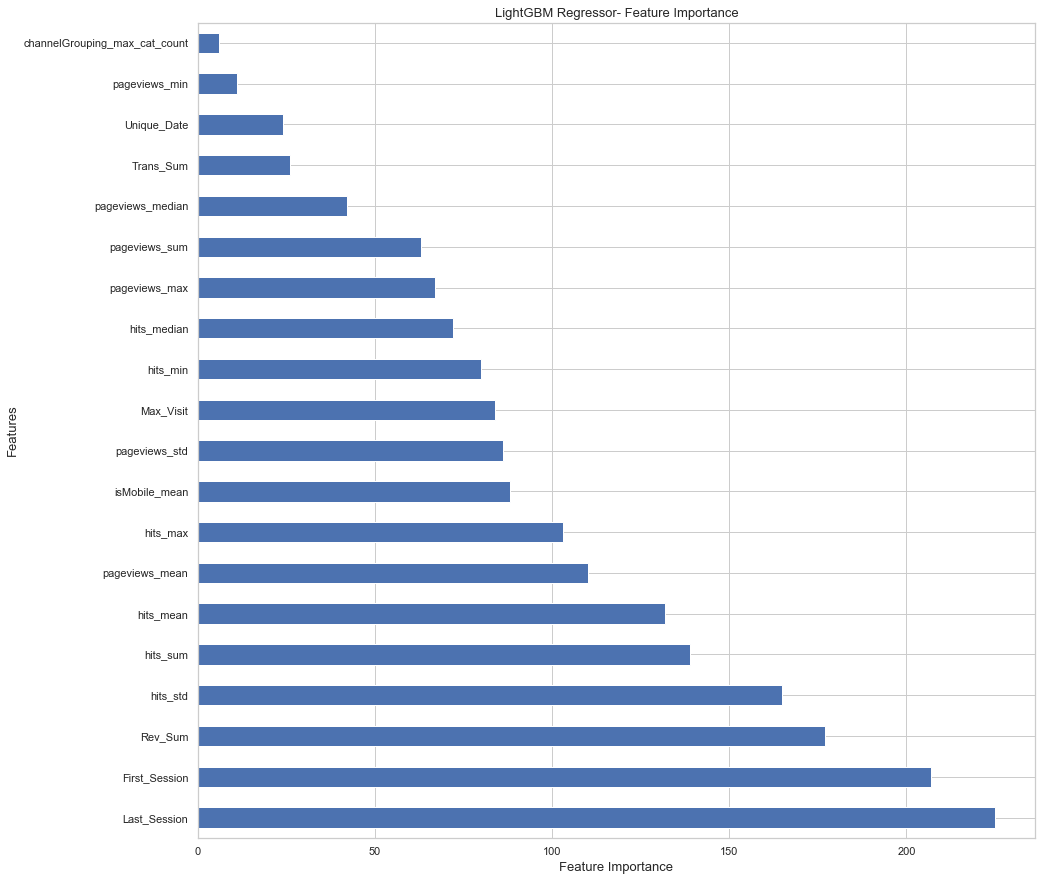

In [36]:
model_save_list, LGBM_regresor, consolidated_train, validation_set, fullData = model_generation_method (df_train, df_test)

In [37]:
def model_predictor(dataframe, model_save_list, LGBM_regresor, name = 'validation'):
    """Takes trained models as input along with the data to predict output labels"""
    
    if (name!='validation'):
        #Full Train using validation set before predicting for submission:
        submission_train = pd.concat([consolidated_train, validation_set], axis=0)
        LGBM_regresor.fit(submission_train[submission_train.RETURN==1].iloc[:,:26].reset_index(drop=True).values, submission_train[submission_train.RETURN==1]['REVENUE'].values)

    #Regressor Prediction
    if (name!='validation'):
        y_submission = LGBM_regresor.predict(dataframe.iloc[:, 1:].values)
    else: 
        y_submission = LGBM_regresor.predict(dataframe.values)
    dataframe['PredictedLogRevenue'] = y_submission
    if (name!='validation'):
        final_submission = dataframe[['fullVisitorId', 'PredictedLogRevenue']]
    else:
        final_submission = dataframe[['PredictedLogRevenue']]
    dataframe.drop(columns='PredictedLogRevenue', inplace=True)

    #Classification Prediction (Random Forest)
    y_proba_list_0 = []
    y_proba_list_1 = []
    for each in model_save_list:
        if (name!='validation'):
            y_proba = each.predict_proba(dataframe.iloc[:, 1:].values)
        else:
            y_proba = each.predict_proba(dataframe.values)
        proba_0 = [every[0] for every in y_proba]
        proba_1 = [every[1] for every in y_proba]
        y_proba_list_0.append(proba_0)
        y_proba_list_1.append(proba_1)

    y_sub_0 = np.array(y_proba_list_0).mean(axis=0)
    y_sub_1 = np.array(y_proba_list_1).mean(axis=0)

    final_submission['Prob_0'] = y_sub_0
    final_submission['Prob_1'] = y_sub_1
    final_submission['PredictedLogRevenue'] = final_submission.apply(lambda x: x['PredictedLogRevenue']*x['Prob_1'],axis=1)
    
    if (name!='validation'):
        return final_submission[['fullVisitorId', 'PredictedLogRevenue']], y_sub_1
    else:
        return final_submission[['PredictedLogRevenue']], y_sub_1

<h1>Final Methods<h1>

In [38]:
def final_fun_1(raw_data):
    """Takes raw data as input and executes the entire pipeline and return prediction on the data passed as input"""
    customer_column = ['fullVisitorId']
    
    #Preprocessing of the data
    preprocessed_data = preprocessing(raw_data, 'raw data')
#     preprocessed_data = raw_data
    
    #Generating features for the preprocessed data file
    preprocessed_data, feature_list = generate_features(preprocessed_data)
    print(preprocessed_data.shape, preprocessed_data.fullVisitorId.nunique())
    preprocessed_data = preprocessed_data[customer_column + feature_list].drop_duplicates().reset_index(drop=True)
    print(preprocessed_data.shape, preprocessed_data.fullVisitorId.nunique())
    
    #Generate Model
    model_save_list, LGBM_regresor, RF_RMSE, LGBM_Reg_RMSE, RF_time, LGBM_Reg_time, consolidated_train, validation_set = model_generation_method (df_train, df_test)
    
    #Model Predictor
    final_predictions, proba_1 = model_predictor(preprocessed_data, model_save_list, LGBM_regresor, name = 'not validation')
    
    return final_predictions

In [39]:
submission = fullData[fullData.date>=pd.to_datetime('20180501', format='%Y%m%d')].reset_index(drop=True)
print("Unique Customers in Submission: ", submission.fullVisitorId.nunique())
final_predictions  = final_fun_1(submission)

Unique Customers in Submission:  296530
(401589, 72) 296530
(296530, 27) 296530


In [40]:
final_predictions.head()

fullVisitorId  PredictedLogRevenue
0  5253503348853343332             0.008378
1  8239645054071672560             0.046472
2  9414444298222421438             0.005281
3   347825224279495991             0.008378
4  2181292687911472329             0.019471

**Comments:**

*1) final_fun_1 takes raw data as input and executes entire pipeline and returns final prediction along with fullVisitorID.*

*2) Here, we are using submission data to test our final_fun_1, which is generating output as expected.* 

In [41]:
def final_fun_2(raw_data, output):
    """Takes raw data and output column as input and return computed metric over this data"""
    
    customer_column = ['fullVisitorId']
    #Preprocessing of the data
    preprocessed_data = preprocessing(raw_data, 'raw data')
    #preprocessed_data = raw_data
    
    #Generating features for the preprocessed data file
    preprocessed_data, feature_list = generate_features(preprocessed_data)
    print(preprocessed_data.shape, preprocessed_data.fullVisitorId.nunique())
    preprocessed_data = preprocessed_data[customer_column + feature_list].drop_duplicates().reset_index(drop=True)
    print(preprocessed_data.shape, preprocessed_data.fullVisitorId.nunique())
    
    #Generate Model
    model_save_list, LGBM_regresor, RF_RMSE, LGBM_Reg_RMSE, RF_time, LGBM_Reg_time, consolidated_train, validation_set = model_generation_method (df_train, df_test)
    
    #Model Predictor
    final_predictions, proba_1 = model_predictor(preprocessed_data, model_save_list, LGBM_regresor, name = 'validation')
    
    #Computing RMSE as the metric to evaluate model
    RMSE_classification = np.sqrt(mean_squared_error(output[0], proba_1))
    RMSE_regression = np.sqrt(mean_squared_error(output[1], final_predictions['PredictedLogRevenue'].values))
    
    return [RMSE_classification, RMSE_regression]

In [42]:
metric = final_fun_2(validation_set.iloc[:,:26], [validation_set['RETURN'].values, validation_set['REVENUE'].values])
print("Classification RMSE on the dataset passed as input: ", metric[0])
print("Regression RMSE on the dataset passed as input: ", metric[1])

Classification RMSE on the dataset passed as input:  0.4063335115710308
Regression RMSE on the dataset passed as input:  0.3043592375307328


**Comments: **

*1) final_fun_2 takes raw data as input and executes entire pipeline and in the end returns two metric as output i.e. RMSE over predicted classification probablity and RMSE over final output column i.e. PredictedLogRevenue*

*2) We are using validation data to test our final_fun_2 method and it is working as expected and we are getting 0.30 RMSE for classification probablities and 0.40 RMSE for final output label PredictedLogRevenue which is the best found across all experiments.*

**Comments for Reading and Preprocessing:**

*1) Since train_v2.csv has file size greater than 25 GB. Hence, I used dask to read the file and then drop 'hits' and 'socialEngagementType' columns as they have constant values throughout the column thus reducing file size.*

*2) df_train.compute() converts dask dataframe to pandas dataframe.*

*3) train_v2_even_less_col.csv is the final file I'll be using moving forward after dropping all sorts of constant columns. Since this file is of much smaller size in comaprision to actual train_v2.csv and can be easily loaded into memory.*

*4) As discussed in the solution documentation, we have combined both train and test file to come up with fullData dataframe where the date range of records is from 2016-08-01 to 2018-10-15*

<img src='https://i.imgur.com/UIngPj2.png' width="40%">

**Comments for Data Preparation:**

*1) generate_output method is used to generate 4 data frames, where 3 will be used for training and 1 for validation in case of hyperparameter tuning and then for submission we shall train on all 4 available sets. This method populates both classification and regression output variables in 4 respective sets.*

*2) As discussed in the First Cut Approach, here I'm dividing my dataset into 4 parts where each set has data for 168 days and output for that set is calculated on 62 days window with a gap of 46 days in between. It is exactly on the same analogy of test and submission file that we have to generate in the end. Please refer doc for further clarification.*

<img src='https://i.imgur.com/SJ11fDz.png' width="40%">

**Comments for Feature Engineering:**

*1) generate_features is a method that computes all the features for every customer of the training/validation set passed to it and returns dataframe with calculated feature values.*

*2) Since we have data in all four sets at customer level i.e. features are calculated at customer level. Hence above we can see that shape of train set is same as number of unique customers in it. Hence it is verified.*

*3) consolidated_train combines all the 3 training sets and will be later used for training of regression and classification models. Whereas, validation_set will be used for hyperparameter tuning of the clasiification and regression models.*

**Comments for Modelling:**

*1) From the various classification and regression models we tried on our data. For Classification, Random Forest Classifier is giving the best results i.e. lowest RMSE(RETURN predicted probability vs actual labels) = 0.4062 and for Regression, LightGBM is giving best results i.e. lowest RMSE = 0.3077 respectively on validation set.*
    
*2) Here, we are facing problem of imbalanced data particulary in case of classification task. We have 1044494 instances of 0(customer did not return) and 6879(customer did return).*

*3) Therefore in order to have equal distribution of output variable for the model we are creating 152 sets of sample data and hence 152 LightGBM classifier models to train on it and hyperparameter tuned on validation data.*

*4) In case of prediction, we are stacking predictions from 152 models and taking the mean of these values.*

*5) We are going to use predicted probability by classification model in our future predictions. We are getting a RMSE of 0.43 for validation set.*

**Reasons for using 152 classifier:**

*1) The consolidated_train dataframe(used for training) has 1051373 number of rows, out of which only RETURN=1(classification label) has 6879 instance only and RETURN=0 has 1044494 instances. Clearly we are dealing with problem of imbalanced dataset.*

*2) Training a single model for such data performs badly for minority class.Therefore in order to have 50%-50% distribution of both lables, I created 152 samples of data by randomly selecting 6879 instances of RETURN=0 for each sample. Therefore, each sample has 6879 random samples(without replacement) of RETURN=0 and same 6879 samples of RETURN=1 throughout. Thus, each sample has total 13758 rows (except last sample) with 50%-50% distribution of both labels.*

*3) Math behind 152 samples and models--> (#instances of RETURN=0 in consolidated_train / #instances of RETURN=1 in consolidated_train) i.e. 1044494/6879 = 152 (approx.)*

**Comments for LGBM Regressor:**

*1) We are training our regression model only for the customers which returned i.e. RETURN = 1. Since these instances are not many hence we have not opted for batch trainig.*

*2) We are getting a RMSE of 0.30 on validation set of data.*

*3) From the above feature importance plot we can see that Last_Session, First_Session, Rev_Sum, hits_sum, etc. are the features that are most important for the model.*


<h1>Submission<h1>

**Comments:**

*1) Our final submission file has 296530 rows corresponding to 296530 customers as expected by the competition.*

*2) With 152 ensemble of Random Forest Classifier and LightGBM Regressor we are getting 0.88669 RMSE and Rank 71 on private leaderboard.*

<img src='https://i.imgur.com/i3WX1tD.jpg' width="100%">

<img src='https://i.imgur.com/tMfzxVk.jpg' width="100%">

In [ ]:
#-----------------------------------------------------END OF FILE--------------------------------------------------------------#